In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
from ast import literal_eval
from dotenv import load_dotenv 

In [2]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")

BENCHMARK_1 = PARENT + os.getenv("BENCHMARK_1")

FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
captions = pd.read_csv("./wikiart_benchmark_3/wikiart_captions.csv")
captions["id"] = captions["id"].apply(lambda x: str(int(x)))

artworks_ids = sorted(captions["id"].unique())
artworks_ids = [str(int(id)) for id in artworks_ids]
print(f"Number of artworks: {len(artworks_ids)}")

    
texts_fr = []
for id in artworks_ids:
    caption = captions[captions["id"] == id]["caption"].values[0]
    texts_fr.append(caption)

captions

Number of artworks: 165


,id,caption
0,62231,"Deux personnes, papillon rouge, danse"
1,61290,"Formes colorées, symmétrie"
2,62054,Formes abstraites dans des tons chauds
3,80914,Un forme gris foncé sur un fond bleu avec un f...
4,79033,Une femme qui danse avec un corde autour d'elle
...,...,...
160,114494,Une grenouille verte et deux vieux hommes autour
161,114105,Un aile blanche
162,122649,Une femme qui tient son bébé dans un landeau r...
163,121708,"Des dessins de visages, des grimaces"


In [4]:
from transformers import MarianMTModel, MarianTokenizer

class TranslationDataset(Dataset):
    def __init__(self, source_texts):
        self.source_texts = source_texts

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        return self.source_texts[idx]
    
def translate_batch(dataloader, model, tokenizer, device):
    translated_texts = []

    for i, batch in enumerate(tqdm(dataloader)):
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        inputs = inputs.to(device)

        # Perform translation
        translated = model.generate(**inputs)

        # Decode translations
        translated_batch = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
        translated_texts.extend(translated_batch)
    
    return translated_texts

In [5]:
TranslationDataset_FR = TranslationDataset(texts_fr)
TranslationDataloader_FR = DataLoader(TranslationDataset_FR, batch_size=16, shuffle=False)

model_fr_en = "Helsinki-NLP/opus-mt-fr-en"
tokenizer_fr_en = MarianTokenizer.from_pretrained(model_fr_en)
model_fr_en = MarianMTModel.from_pretrained(model_fr_en).to(device)

texts_en = translate_batch(texts_fr, model_fr_en, tokenizer_fr_en, device)
print(texts_en)

100%|██████████| 165/165 [00:25<00:00,  6.60it/s]

['A red butterfly on an orange background', 'Black features on a white background, pattern', 'Two red diamond on a black geometric shape on a white background', 'A white face with makeup melts on the edge of a table', 'A party in a city, del a snow, a city center', 'Two people in a kitchen, one person sitting, one person standing, cardboard', 'A port with sailboats, a lighthouse', 'A brown field with clouds in the sky', 'A vegetable garden with a farm in the background and vegetable plans', "An old man holds a spear in his hand, he's devout, halo around his head", 'A table and two chairs side views', 'Soldiers, crowds, fish, hay', 'A table returned to the ground', 'A simple drawing of a blue figure', 'A metal stool with a black cushion', 'three drawers, one orange and two black, one white background', 'A line dotted with bright bulbs on a white background', 'A striped shape in yellow and black', 'a sonette with red threads, a knot', 'A piece of cardboard on a white background', 'A sket

In [6]:
TranslationDataset_EN = TranslationDataset(texts_en)
TranslationDataloader_EN = DataLoader(TranslationDataset_EN, batch_size=16, shuffle=False)

model_en_nl = "Helsinki-NLP/opus-mt-en-nl" # We cannot translate from French to Dutch using opus
tokenizer_en_nl = MarianTokenizer.from_pretrained(model_en_nl)
model_en_nl = MarianMTModel.from_pretrained(model_en_nl).to(device)

texts_nl = translate_batch(texts_en, model_en_nl, tokenizer_en_nl, device)
print(texts_nl)

100%|██████████| 165/165 [00:28<00:00,  5.80it/s]

['Een rode vlinder op een oranje achtergrond', 'Zwarte kenmerken op een witte achtergrond, patroon', 'Twee rode diamant op een zwarte geometrische vorm op een witte achtergrond', 'Een wit gezicht met make-up smelt op de rand van een tafel', 'Een feest in een stad, del een sneeuw, een centrum', 'Twee personen in een keuken, één persoon zittend, één persoon staand, karton', 'Een haven met zeilboten, een vuurtoren', 'Een bruin veld met wolken in de lucht', 'Een moestuin met een boerderij op de achtergrond en plantaardige plannen', 'Een oude man houdt een speer in zijn hand, hij is vroom, halo rond zijn hoofd', 'Een tafel en twee stoelen zijaanzicht', 'Soldaten, menigte, vis, hooi', 'Een tafel keerde terug naar de grond', 'Een eenvoudige tekening van een blauwe figuur', 'Een metalen kruk met een zwart kussen', 'drie lades, één oranje en twee zwart, één witte achtergrond', 'Een lijn bezaaid met heldere bollen op een witte achtergrond', 'Een gestreepte vorm in geel en zwart', 'een sonette me

ID: 100935
French caption: Des traits noirs sur un fond blanc, motif
English caption: Black features on a white background, pattern
Dutch caption: Zwarte kenmerken op een witte achtergrond, patroon


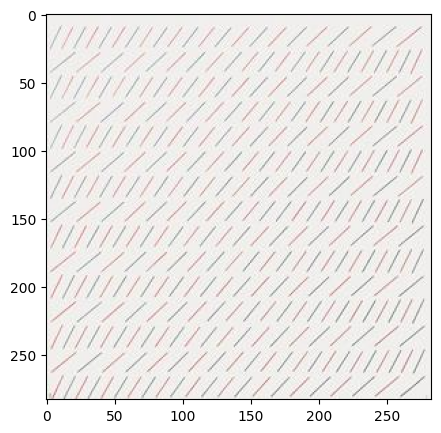

In [7]:
files_in_folder = os.listdir("./wikiart_benchmark_3/wikiart_images/")
id_to_path = {}
for file in files_in_folder:
    id = file.split(".")[0]
    id_to_path[id] = f"./wikiart_benchmark_3/wikiart_images/{file}"

# Open a random image
import matplotlib.pyplot as plt
sID = list(id_to_path.keys())[1]

index = artworks_ids.index(sID)
text_fr = texts_fr[index]
text_en = texts_en[index]
text_nl = texts_nl[index]

print(f"ID: {sID}")
print(f"French caption: {text_fr}")
print(f"English caption: {text_en}")
print(f"Dutch caption: {text_nl}")

fig, ax = plt.subplots(figsize=(5, 5))
image = Image.open(id_to_path[sID])
ax.imshow(image)
plt.show()

# Get the model

In [8]:
base_model_february_finetuned = "openai/clip-vit-large-patch14" # art-base
base_model_march_finetuned = "openai/clip-vit-large-patch14" # art-base

base_model_mini = "openai/clip-vit-base-patch32" # art-mini
base_model_base = "openai/clip-vit-large-patch14" # art-base
base_model_large = "openai/clip-vit-large-patch14-336" # art-large

basic_mini = "openai/clip-vit-base-patch32"
basic_base = "openai/clip-vit-large-patch14"
basic_large = "openai/clip-vit-large-patch14-336"

In [9]:
model_name = "art-large" # OK

model_name = "art-base" # OK 
model_name = "basic-base" # OK 
model_name = "february_finetuned" # OK 
model_name = "march_finetuned" # OK 

model_name = "art-mini" # OK 
model_name = "basic-mini" # OK 
model_name = "basic-large" # OK

print(f"Running benchmark on: {model_name}")

Running benchmark on: basic-large


In [10]:
# Create folder to export the results
RESULT_FOLDER = "../benchmarks/benchmark_3"
os.makedirs(RESULT_FOLDER, exist_ok=True)

In [11]:
root = "../../private_data/MODELS/"

In [12]:
if model_name == "february_finetuned":
  processor = CLIPProcessor.from_pretrained(base_model_base)
  model = CLIPModel.from_pretrained(base_model_base).to(device)
  model_weights_path = root + "2025-02-05 17_09_07_allFocus_5.pt"
  model.load_state_dict(torch.load(model_weights_path, weights_only=True))
  BATCH_SIZE = 2 # 32

elif model_name == "march_finetuned":
  processor = CLIPProcessor.from_pretrained(base_model_base)
  model = CLIPModel.from_pretrained(base_model_base).to(device)
  model_weights_path = root + "2025-03-29 16 59 53_allFocus_5.pt"
  model.load_state_dict(torch.load(model_weights_path, weights_only=True))
  BATCH_SIZE = 2 # 32

elif model_name == "art-mini":
  processor = CLIPProcessor.from_pretrained(base_model_mini)
  model = CLIPModel.from_pretrained(base_model_mini).to(device)
  model_weights_path = root + "art-mini.pt"
  model.load_state_dict(torch.load(model_weights_path, weights_only=True))
  BATCH_SIZE = 8 # 256

elif model_name == "art-base":
  processor = CLIPProcessor.from_pretrained(base_model_base)
  model = CLIPModel.from_pretrained(base_model_base).to(device)
  model_weights_path = root + "art-base.pt"
  model.load_state_dict(torch.load(model_weights_path, weights_only=True))
  BATCH_SIZE = 2 # 32

elif model_name == "art-large":
  processor = CLIPProcessor.from_pretrained(base_model_large)
  model = CLIPModel.from_pretrained(base_model_large).to(device)
  model_weights_path = root + "art-large.pt"
  model.load_state_dict(torch.load(model_weights_path, weights_only=True))
  BATCH_SIZE = 1 # 16

elif model_name == "basic-mini":
  processor = CLIPProcessor.from_pretrained(basic_mini)
  model = CLIPModel.from_pretrained(basic_mini).to(device)
  BATCH_SIZE = 8 # 256

elif model_name == "basic-base":
  processor = CLIPProcessor.from_pretrained(basic_base)
  model = CLIPModel.from_pretrained(basic_base).to(device)
  BATCH_SIZE = 2 # 32

elif model_name == "basic-large":
  processor = CLIPProcessor.from_pretrained(basic_large)
  model = CLIPModel.from_pretrained(basic_large).to(device)
  BATCH_SIZE = 1 # 16
else:
  processor = CLIPProcessor.from_pretrained(base_model_base)
  model = CLIPModel.from_pretrained(base_model_base).to(device)
  model_weights_path = root + f"{model_name}.pt"
  model.load_state_dict(torch.load(model_weights_path, weights_only=True))
  BATCH_SIZE = 2 # 32

print(f"Running benchmark on: {model_name} with batch size: {BATCH_SIZE}")

Running benchmark on: basic-large with batch size: 1


# Configure the benchmark

In [13]:
best_workers = 0
criterion = nn.CrossEntropyLoss()

In [14]:
class ArtworksImages(Dataset):
    def __init__(self, ids):
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        id = self.ids[idx]
        path = id_to_path[id]

        image = Image.open(path)

        return image

def ArtworksImagesBBuilder(images):
    inputs = processor(text=[""] * len(images), images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

artworks_dataset = ArtworksImages(artworks_ids)
artworks_dataloader = DataLoader(
    artworks_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=best_workers,
    collate_fn=ArtworksImagesBBuilder,
    pin_memory=True,
)

def compute_images_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader, desc="Computing artworks embeddings", unit="batch"):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            pixel_values = sample['pixel_values'].to(device)

            # Compute image embeddings
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.flatten(1)

            embeddings.append(image_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

artworks_embeddings_np_array = compute_images_embeddings(artworks_dataloader, model, device)
artworks_embeddings = {}
for i, id in enumerate(artworks_ids):
    artworks_embeddings[id] = artworks_embeddings_np_array[i]

Computing artworks embeddings: 100%|██████████| 165/165 [00:11<00:00, 13.98batch/s]


In [15]:
def compute_textual_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader, desc="Computing textual embeddings", unit="batch"):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)

            # Compute the embeddings
            text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.flatten(1)

            embeddings.append(text_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

def TextBBuilder(samples):
    inputs = processor(text=samples, return_tensors="pt", padding=True, truncation=True)
    return inputs

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        text = self.texts[idx]
        return text

text_embeddings_per_lang = {}

for lang in ["fr", "en", "nl"]:
    print(f"Computing textual embeddings for language: {lang}")
    if lang == "fr":
        texts = texts_fr
    elif lang == "en":
        texts = texts_en
    elif lang == "nl":
        texts = texts_nl

    text_dataset = TextDataset(texts)
    text_dataloader = DataLoader(
        text_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=best_workers,
        collate_fn=TextBBuilder,
        pin_memory=True,
    )

    textual_embeddings_np_array = compute_textual_embeddings(text_dataloader, model, device)
    text_embeddings_per_lang[lang] = textual_embeddings_np_array

Computing textual embeddings for language: fr


Computing textual embeddings: 100%|██████████| 165/165 [00:01<00:00, 120.22batch/s]


Computing textual embeddings for language: en


Computing textual embeddings: 100%|██████████| 165/165 [00:01<00:00, 122.27batch/s]


Computing textual embeddings for language: nl


Computing textual embeddings: 100%|██████████| 165/165 [00:01<00:00, 124.53batch/s]


# Benchmarking methods

In [16]:
def get_average_position(cosine_similarities):
    positions = []
    average_position = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        sorted_indices = [int(p) for p in sorted_indices]
        positions.append(sorted_indices)
        average_position += rank
    average_position /= len(cosine_similarities)
    return average_position, positions

def get_MRR(cosine_similarities):
    mrr = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        mrr += 1 / rank
    mrr /= len(cosine_similarities)
    return mrr

def get_recall_at_k(cosine_similarities, k):
    recall_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        if i in sorted_indices[:k]:
            recall_at_k += 1
    recall_at_k /= len(cosine_similarities)
    return recall_at_k

def get_nDCG_at_k(cosine_similarities, k):
    nDCG_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        nDCG_at_k += 1 / np.log2(rank + 1) if rank <= k else 0
    nDCG_at_k /= len(cosine_similarities)
    return nDCG_at_k

def get_metrics_row(cosine_similarities):
    recalls_k = [1,3,5,10]
    nDCG_k = [1,3,5,10]

    average_position, positions = get_average_position(cosine_similarities)
    mrr = get_MRR(cosine_similarities)
    recalls = [get_recall_at_k(cosine_similarities, k) for k in recalls_k]
    nDCGs = [get_nDCG_at_k(cosine_similarities, k) for k in nDCG_k]

    metrics = [average_position, mrr] + recalls + nDCGs

    return metrics, positions

In [17]:
def run_benchmark():
    results = pd.DataFrame(columns=[
        "lang",
        "average_position",
        "mrr",
        "recall@1",
        "recall@3",
        "recall@5",
        "recall@10",
        "nDCG@1",
        "nDCG@3",
        "nDCG@5",
        "nDCG@10"
    ])

    for lang in ["fr", "en", "nl"]:
        textual_embeddings = text_embeddings_per_lang[lang]
        cosine_similarities = textual_embeddings @ artworks_embeddings_np_array.T
        # Measure the metrics
        metrics, positions = get_metrics_row(cosine_similarities)

        results.loc[len(results)] = [lang] + metrics

    return results

In [ ]:
results = run_benchmark()
results.to_csv(f"{RESULT_FOLDER}/benchmark_results_{model_name}.csv", index=False)
print("Benchmark completed and results saved.")
results

Benchmark completed and results saved.


,lang,average_position,mrr,recall@1,recall@3,recall@5,recall@10,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,fr,8.012121,0.545605,0.400000,0.636364,0.715152,0.812121,0.400000,0.538020,0.571155,0.603442
1,en,3.078788,0.763650,0.648485,0.842424,0.903030,0.945455,0.648485,0.767673,0.792712,0.806218
2,nl,18.587879,0.386170,0.266667,0.424242,0.503030,0.624242,0.266667,0.359738,0.392342,0.430661
